In [1]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, classification_report,confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns
from numpy import random
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau


import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

In [2]:
BATCH_SIZE=32
VOCAB_SIZE=10000
SEQUENCE_LENGTH=100
EMBEDDING_DIM=64

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
STOPWORDS = set([
    "a", "about", "above", "after", "again", "against", "all", "am",
    "an", "and", "any", "are", "aren't", "as", "at", "be", "because", 
    "been", "before", "being", "below", "between", "both", "but", "by", 
    "can't", "cannot", "could", "couldn't", "did", "didn't", "do", 
    "does", "doesn't", "doing", "don't", "down", "during", "each", 
    "few", "for", "from", "further", "had", "hadn't", "has", "hasn't", 
    "have", "haven't", "having", "he", "he'd", "he'll", "he's", 
    "her", "here", "here's", "hers", "herself", "him", "himself", 
    "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", 
    "in", "into", "is", "isn't", "it", "it's", "its", "itself", 
    "just", "ll", "m", "ma", "me", "might", "mightn't", "more", 
    "most", "must", "mustn't", "my", "myself", "needn't", "no", 
    "nor", "not", "now", "o", "of", "off", "on", "once", "only", 
    "or", "other", "our", "ours", "ourselves", "out", "over", 
    "own", "re", "s", "same", "shan't", "she", "she'd", "she'll", 
    "she's", "should", "shouldn't", "so", "some", "such", "t", 
    "than", "that", "that's", "the", "their", "theirs", "them", 
    "themselves", "then", "there", "there's", "these", "they", 
    "they'd", "they'll", "they're", "they've", "this", "those", 
    "through", "to", "too", "under", "until", "up", "ve", 
    "very", "was", "wasn't", "we", "we'd", "we'll", "we're", 
    "we've", "were", "weren't", "what", "what's", "when", 
    "when's", "where", "where's", "which", "while", "who", 
    "who's", "whom", "why", "why's", "will", "with", "won't", 
    "would", "wouldn't", "y", "you", "you'd", "you'll", 
    "you're", "you've", "your", "yours", "yourself", "yourselves"
])

In [4]:
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    no_punctuation = tf.strings.regex_replace(no_tag, "[%s]" % re.escape(string.punctuation), "")
    
    words = tf.strings.split(no_punctuation)
    
    filtered_words = tf.ragged.boolean_mask(words, ~tf.reduce_any(tf.equal(words[:, None], list(STOPWORDS)), axis=-1))
    
    return tf.strings.reduce_join(filtered_words, separator=' ', axis=-1)


In [5]:
df = pd.read_csv("/kaggle/input/hierarchical-text-classification/train_40k.csv")
df.head()

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
0,B000E46LYG,Golden Valley Natural Buffalo Jerky,A3MQDNGHDJU4MK,0/0,3.0,-1,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,B000GRA6N8,Westing Game,unknown,0/0,5.0,860630400,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,B000GRA6N8,Westing Game,unknown,0/0,5.0,883008000,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,B000GRA6N8,Westing Game,unknown,0/0,5.0,897696000,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,B00000DMDQ,I SPY A is For Jigsaw Puzzle 63pc,unknown,2/4,5.0,911865600,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles


In [6]:
df = df[['Text','Cat1']]
df.head()

,Text,Cat1
0,The description and photo on this product need...,grocery gourmet food
1,This was a great book!!!! It is well thought t...,toys games
2,"I am a first year teacher, teaching 5th grade....",toys games
3,I got the book at my bookfair at school lookin...,toys games
4,Hi! I'm Martine Redman and I created this puzz...,toys games


In [7]:
df.shape

(40000, 2)

In [8]:
encoder = LabelEncoder()
df.loc[:, 'label'] = encoder.fit_transform(df[['Cat1']])
df = df[['Text','label']]
df.head()

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Text,label
0,The description and photo on this product need...,2
1,This was a great book!!!! It is well thought t...,5
2,"I am a first year teacher, teaching 5th grade....",5
3,I got the book at my bookfair at school lookin...,5
4,Hi! I'm Martine Redman and I created this puzz...,5


In [9]:
df.label.value_counts()

label
5    10266
3     9772
1     5846
0     5637
4     4862
2     3617
Name: count, dtype: int64

In [10]:
balanced_df = df.groupby('label').apply(lambda x: x.sample(3617)).reset_index(drop=True)
balanced_df.head()

/tmp/ipykernel_30/2679640453.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('label').apply(lambda x: x.sample(3617)).reset_index(drop=True)


,Text,label
0,I love the triangular handle on this car seat....,0
1,We received this Snugli carrier as a gift. We ...,0
2,The Baby Bjorn active felt very secure and eas...,0
3,We've tried just about every child-resistant d...,0
4,I have tried most bottles that are sold in sto...,0


In [11]:
balanced_df = shuffle(balanced_df)
balanced_df.label.value_counts()

label
4    3617
5    3617
2    3617
0    3617
3    3617
1    3617
Name: count, dtype: int64

In [12]:
df_train,df_test = train_test_split(balanced_df,test_size=0.2)

df_train.shape,df_test.shape

((17361, 2), (4341, 2))

In [13]:
df_train,df_val = train_test_split(df_train,test_size=0.2)

df_train.shape,df_val.shape

((13888, 2), (3473, 2))

In [14]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [15]:
df_train_ds = tf.data.Dataset.from_tensor_slices((df_train['Text'].values, df_train['label'].values))
df_val_ds = tf.data.Dataset.from_tensor_slices((df_val['Text'].values, df_val['label'].values))
df_test_ds = tf.data.Dataset.from_tensor_slices((df_test['Text'].values, df_test['label'].values))


In [16]:
training_data=df_train_ds.map(lambda x,y:x)
vectorize_layer.adapt(training_data)

In [17]:
for batch in df_train_ds.take(1): 
    print(batch)


(<tf.Tensor: shape=(), dtype=string, numpy=b"I have had locks for 7 years and began to experience serious build up issues. This stuff works. I just used it and soaked my hair 3 times and each time the water was full of debris etc. and I wash my hair weekly. If this stuff works, I will be back for more-but I'm excited bc the smell is gone now!">, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [18]:
len(vectorize_layer.get_vocabulary())

10000

In [19]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [20]:
df_train_ds = df_train_ds.map(vectorizer)
df_val_ds = df_val_ds.map(vectorizer)
df_test_ds = df_test_ds.map(vectorizer)

In [21]:
for batch in df_train_ds.take(1):
    print(batch)


(<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([   2,    4,   21, 2527,  563,   92, 1050,  675, 1529, 1102,   26,
        772,  237,  103,    2,   18,   55, 3328,    3,   61,  116,  215,
        248,   40,  133,  395, 5107,  418,    2,  464,    3,   61, 2800,
        237,  103,    2,   34,   78,    1,   71,  747, 1919,  190,  576,
         56,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [22]:
df_train_ds = df_train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
df_val_ds = df_val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
df_test_ds = df_test_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
for batch in df_train_ds.take(1):
    print(batch)

(<tf.Tensor: shape=(32, 100), dtype=int64, numpy=
array([[   2,    4,   21, ...,    0,    0,    0],
       [ 341,  510,  661, ...,    0,    0,    0],
       [1818,  615,  879, ...,    0,    0,    0],
       ...,
       [ 362,  236,    5, ...,    0,    0,    0],
       [   3,  134,    1, ...,    0,    0,    0],
       [  68, 1888,  613, ...,    0,    0,    0]])>, <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([1, 3, 5, 4, 5, 2, 2, 1, 4, 1, 3, 0, 2, 5, 4, 1, 2, 5, 1, 0, 4, 2,
       5, 1, 4, 0, 0, 0, 0, 2, 4, 5])>)


In [24]:
early_stop = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

## RNN 

In [106]:
model_rnn = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    SimpleRNN(64, return_sequences=True),
    SimpleRNN(64, return_sequences=True),
    SimpleRNN(32),
    Dense(32, activation='relu'),
    Dense(6, activation='softmax'),
])

model_rnn.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_22 (SimpleRNN)       │ (None, 100, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_23 (SimpleRNN)       │ (None, 100, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_24 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 660,870 (2.52 MB)

 Trainable params: 660,870 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
model_rnn.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [108]:
history=model_rnn.fit(
    df_train_ds,
    validation_data=df_val_ds,
    epochs=30,
    callbacks=[early_stop])

Epoch 1/30

434/434 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - accuracy: 0.1926 - loss: 1.8084 - val_accuracy: 0.3167 - val_loss: 1.5768

Epoch 2/30

434/434 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.3461 - loss: 1.5186 - val_accuracy: 0.4296 - val_loss: 1.2693

Epoch 3/30

434/434 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.4599 - loss: 1.2399 - val_accuracy: 0.4840 - val_loss: 1.2218

Epoch 4/30

434/434 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step - accuracy: 0.5120 - loss: 1.1406 - val_accuracy: 0.5073 - val_loss: 1.1943

Epoch 5/30

434/434 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.5854 - loss: 1.0053 - val_accuracy: 0.5894 - val_loss: 1.0688

Epoch 6/30

434/434 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step - accuracy: 0.6317 - loss: 0.9037 - val_accuracy: 0.5828 - val_loss: 1.0511

Epoch 7/30

434/434 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step - accuracy: 0.6690 - loss: 0.8122 - val_accuracy: 0.5716 - val_loss: 1.1133

Epoch 8/30

434/434 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.6870 - 

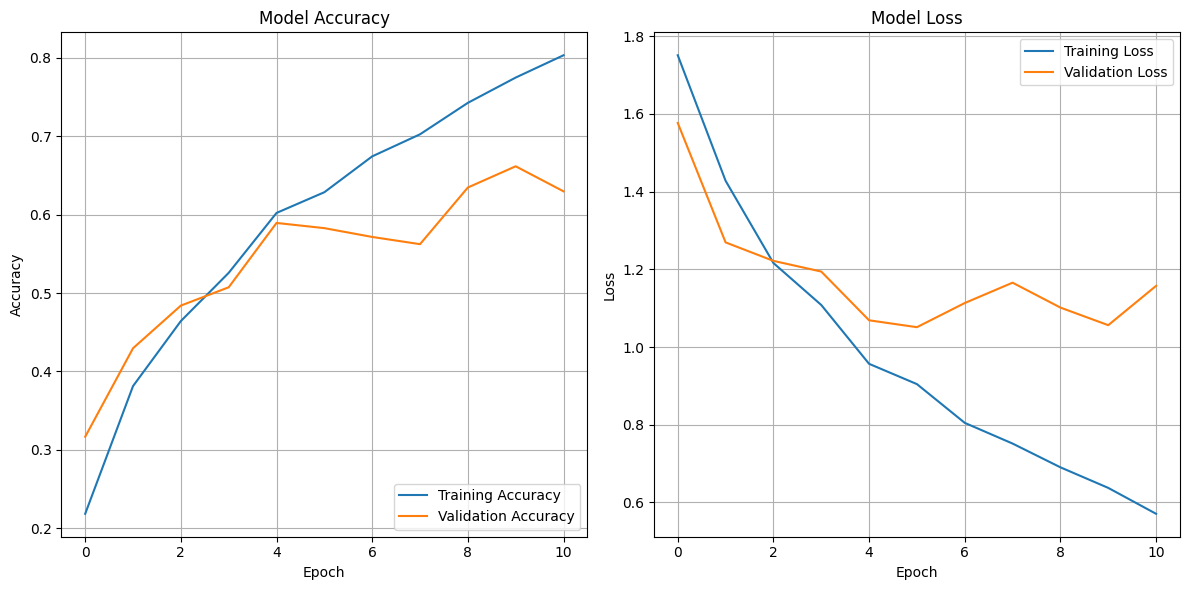

In [110]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [111]:
all_preds = []
all_labels = []

for batch in df_test_ds.take(100):
    inputs, labels = batch
    if inputs.shape[0] != BATCH_SIZE:
        print("Last batch detected with smaller size:", inputs.shape)
    else:
        preds = model_rnn.predict(inputs,verbose=0)
        preds_classes = np.argmax(preds, axis=1)
        all_preds.extend(preds_classes)
        all_labels.extend(labels.numpy())


print(classification_report(all_labels, all_preds, target_names=encoder.classes_))

                      precision    recall  f1-score   support



       baby products       0.49      0.66      0.56       547

              beauty       0.48      0.79      0.60       502

grocery gourmet food       0.80      0.85      0.83       525

health personal care       0.44      0.11      0.18       548

        pet supplies       0.46      0.30      0.36       548

          toys games       0.77      0.84      0.80       530



            accuracy                           0.59      3200

           macro avg       0.57      0.59      0.56      3200

        weighted avg       0.57      0.59      0.55      3200




<Figure size 1500x1000 with 0 Axes>

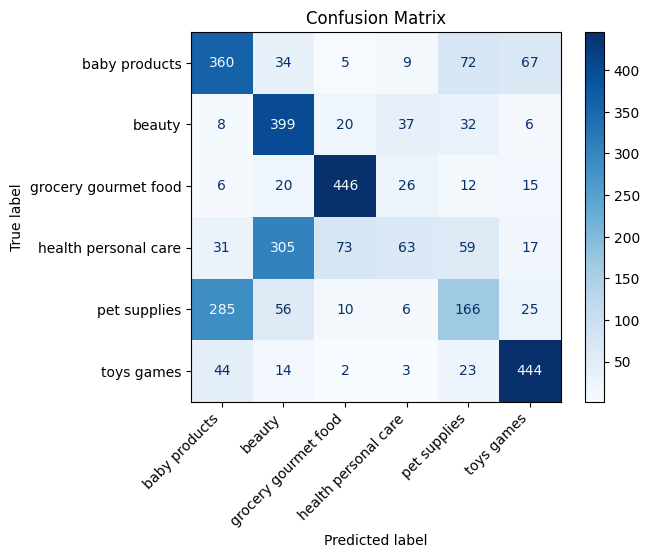

In [112]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('Confusion Matrix')
plt.show()

## LSTM

In [28]:
model_lstm=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    Bidirectional(LSTM(64,return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6,activation='softmax'),
])
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 751,814 (2.87 MB)

 Trainable params: 751,814 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model_lstm.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [30]:
history=model_lstm.fit(
    df_train_ds,
    validation_data=df_val_ds,
    epochs=30,
    callbacks=[early_stop])

Epoch 1/30

434/434 ━━━━━━━━━━━━━━━━━━━━ 62s 126ms/step - accuracy: 0.1872 - loss: 1.7883 - val_accuracy: 0.3265 - val_loss: 1.5948

Epoch 2/30

434/434 ━━━━━━━━━━━━━━━━━━━━ 53s 123ms/step - accuracy: 0.3254 - loss: 1.5169 - val_accuracy: 0.4371 - val_loss: 1.3084

Epoch 3/30

434/434 ━━━━━━━━━━━━━━━━━━━━ 54s 124ms/step - accuracy: 0.4481 - loss: 1.2771 - val_accuracy: 0.5839 - val_loss: 1.0680

Epoch 4/30

434/434 ━━━━━━━━━━━━━━━━━━━━ 53s 123ms/step - accuracy: 0.6194 - loss: 0.9965 - val_accuracy: 0.6444 - val_loss: 0.9419

Epoch 5/30

434/434 ━━━━━━━━━━━━━━━━━━━━ 54s 124ms/step - accuracy: 0.7118 - loss: 0.7936 - val_accuracy: 0.7040 - val_loss: 0.8501

Epoch 6/30

434/434 ━━━━━━━━━━━━━━━━━━━━ 54s 125ms/step - accuracy: 0.7783 - loss: 0.6572 - val_accuracy: 0.7161 - val_loss: 0.8444

Epoch 7/30

434/434 ━━━━━━━━━━━━━━━━━━━━ 82s 124ms/step - accuracy: 0.8201 - loss: 0.5598 - val_accuracy: 0.7201 - val_loss: 0.8411

Epoch 8/30

434/434 ━━━━━━━━━━━━━━━━━━━━ 54s 125ms/step - accuracy: 0

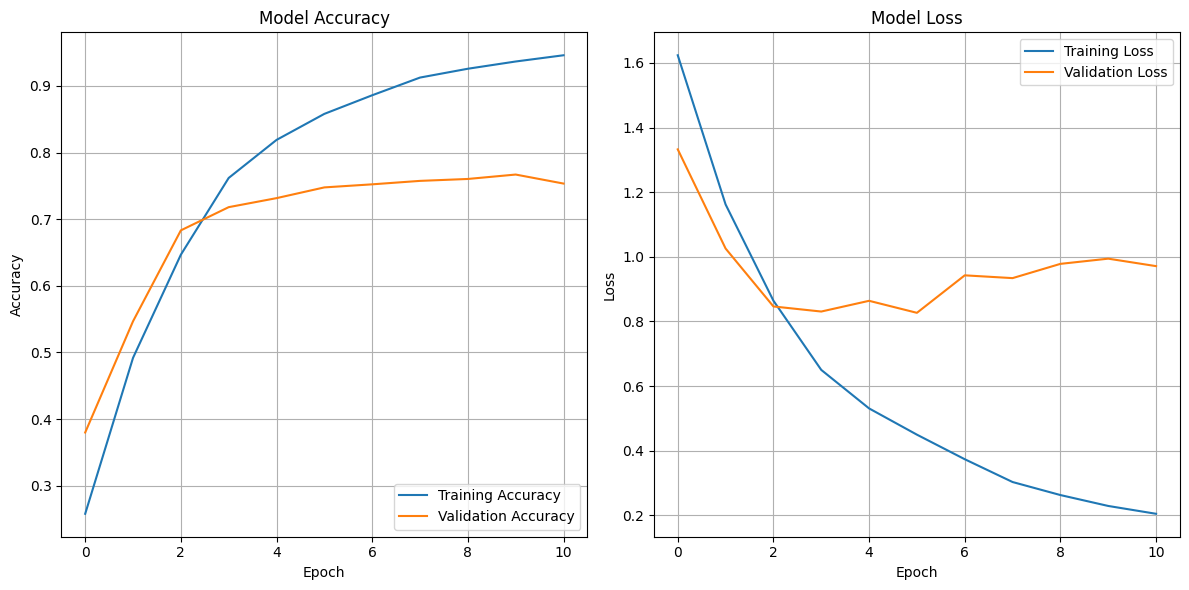

In [132]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [133]:
all_preds = []
all_labels = []

for batch in df_test_ds.take(100):
    inputs, labels = batch
    if inputs.shape[0] != BATCH_SIZE:
        print("Last batch detected with smaller size:", inputs.shape)
    else:
        preds = model_lstm.predict(inputs,verbose=0)
        preds_classes = np.argmax(preds, axis=1)
        all_preds.extend(preds_classes)
        all_labels.extend(labels.numpy())


print(classification_report(all_labels, all_preds, target_names=encoder.classes_))

                      precision    recall  f1-score   support



       baby products       0.73      0.77      0.75       547

              beauty       0.69      0.67      0.68       502

grocery gourmet food       0.75      0.83      0.79       525

health personal care       0.49      0.54      0.51       548

        pet supplies       0.80      0.69      0.74       548

          toys games       0.87      0.78      0.82       530



            accuracy                           0.71      3200

           macro avg       0.72      0.71      0.72      3200

        weighted avg       0.72      0.71      0.72      3200




<Figure size 1500x1000 with 0 Axes>

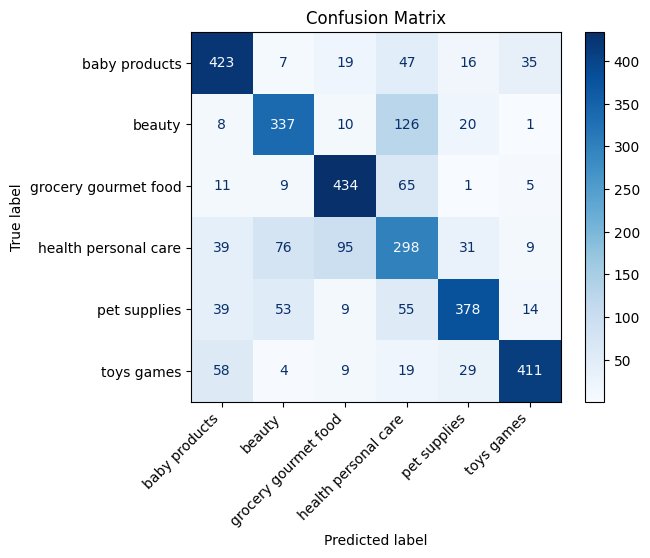

In [134]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('Confusion Matrix')
plt.show()

In [25]:
model_lstm2=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    Bidirectional(LSTM(64,return_sequences=True)),
    BatchNormalization(),
    Bidirectional(LSTM(64,return_sequences=True)),
    BatchNormalization(),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='tanh'),
    Dense(6,activation='softmax'),
])
model_lstm2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 909,030 (3.47 MB)

 Trainable params: 908,518 (3.47 MB)

 Non-trainable params: 512 (2.00 KB)

In [26]:
model_lstm2.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(3e-4),
              metrics=['accuracy'])

In [27]:
history=model_lstm2.fit(
    df_train_ds,
    validation_data=df_val_ds,
    epochs=30,
    callbacks=[early_stop,reduce_lr])

Epoch 1/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 123s 254ms/step - accuracy: 0.3706 - loss: 1.5226 - val_accuracy: 0.6870 - val_loss: 0.9076 - learning_rate: 3.0000e-04
Epoch 2/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 108s 248ms/step - accuracy: 0.7672 - loss: 0.6891 - val_accuracy: 0.7440 - val_loss: 0.7674 - learning_rate: 3.0000e-04
Epoch 3/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 108s 248ms/step - accuracy: 0.8609 - loss: 0.4423 - val_accuracy: 0.7815 - val_loss: 0.7001 - learning_rate: 3.0000e-04
Epoch 4/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 108s 249ms/step - accuracy: 0.9061 - loss: 0.3088 - val_accuracy: 0.7806 - val_loss: 0.7450 - learning_rate: 3.0000e-04
Epoch 5/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 102s 235ms/step - accuracy: 0.9322 - loss: 0.2303 - val_accuracy: 0.7800 - val_loss: 0.7904 - learning_rate: 3.0000e-04
Epoch 6/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 101s 233ms/step - accuracy: 0.9534 - loss: 0.1707 - val_accuracy: 0.7656 - val_loss: 0.9088 - learning_rate: 3.0000e-04
Epoch 7/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 

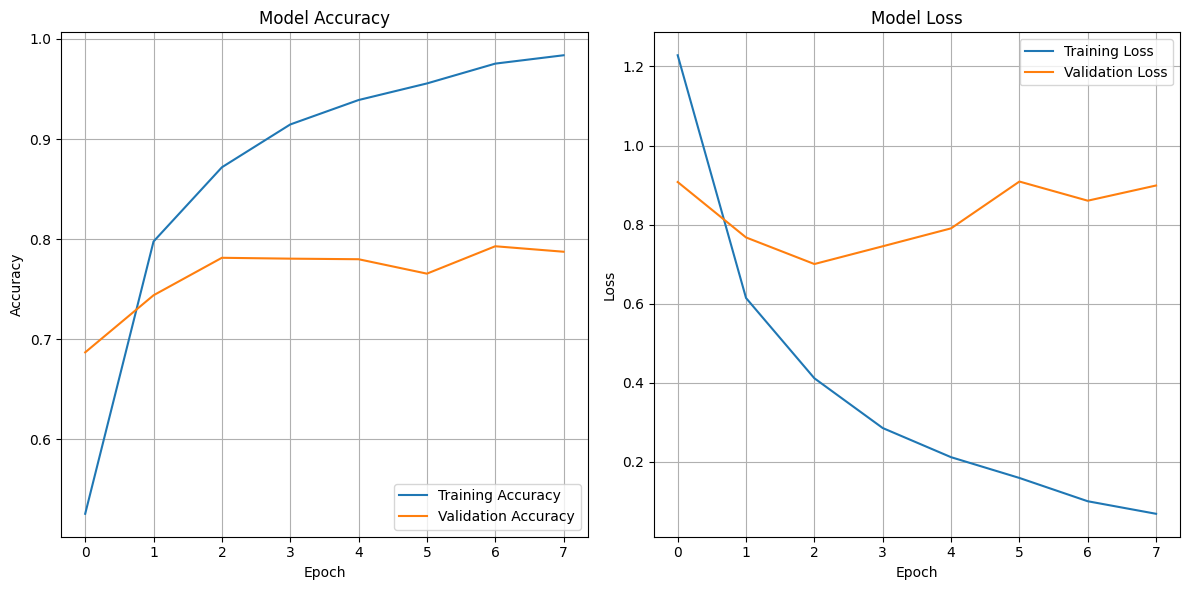

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [29]:
all_preds = []
all_labels = []

for batch in df_test_ds.take(100):
    inputs, labels = batch
    if inputs.shape[0] != BATCH_SIZE:
        print("Last batch detected with smaller size:", inputs.shape)
    else:
        preds = model_lstm2.predict(inputs,verbose=0)
        preds_classes = np.argmax(preds, axis=1)
        all_preds.extend(preds_classes)
        all_labels.extend(labels.numpy())


print(classification_report(all_labels, all_preds, target_names=encoder.classes_))

                      precision    recall  f1-score   support

       baby products       0.86      0.76      0.80       547
              beauty       0.72      0.84      0.78       502
grocery gourmet food       0.85      0.84      0.84       525
health personal care       0.61      0.70      0.65       548
        pet supplies       0.86      0.83      0.84       548
          toys games       0.89      0.78      0.83       530

            accuracy                           0.79      3200
           macro avg       0.80      0.79      0.79      3200
        weighted avg       0.80      0.79      0.79      3200



<Figure size 1500x1000 with 0 Axes>

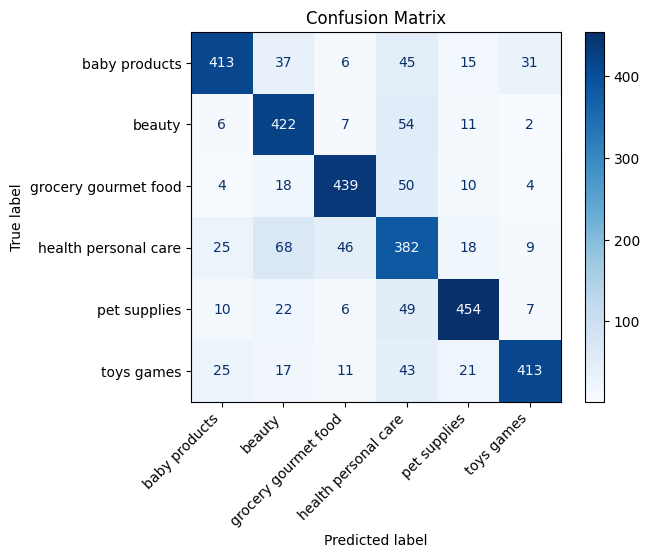

In [31]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('Confusion Matrix')
plt.show()